In [7]:
import pandahouse as ph
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import datetime

# ETL (PYTHON + SQL). Подключение к clickhouse и анализ датафрейма в Python.

In [5]:
#подключение
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Выгрузим из таблицы данные о цене в зависимости от типа жилья. 

In [8]:
q = '''
    SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    toFloat32OrNull(review_scores_rating) as review_scores_rating
    FROM ldn_listings
    WHERE review_scores_rating != 0
    ORDER BY id ASC
    LIMIT 1000
    '''
data = ph.read_clickhouse(query=q, connection=connection_default)
data

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [9]:
#группируем данные по типу комнаты
data = data.groupby('room_type',as_index=False)\
    .agg({'price': 'mean','review_scores_rating': 'mean'})\
    .sort_values('price',ascending = False)

In [10]:
data

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


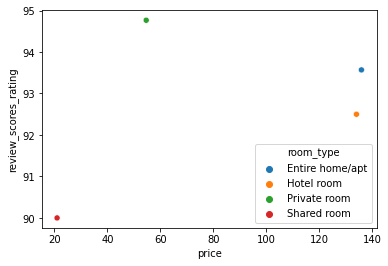

In [56]:
#построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья
sns.scatterplot(data=logsss, x="price", y="review_scores_rating",hue="room_type")

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления

In [17]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
    host_id,
    host_verifications
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
data2 = ph.read_clickhouse(query=q, connection=connection_default)

In [18]:
data2

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1543,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1544,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."
1545,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."
1546,2730552,"['email', 'phone', 'facebook', 'jumio', 'offli..."


In [22]:
#предподготовка данных
data2.host_verifications = data2.host_verifications\
                                        .apply (lambda x:x\
                                        .strip('[]')\
                                        .replace("'",'')\
                                        .split(', '))

In [23]:
data2.explode('host_verifications').host_verifications.value_counts().to_frame(name='count') 

,count
phone,1548
email,1531
reviews,1493
government_id,1373
jumio,1279
offline_government_id,573
work_email,322
facebook,307
selfie,300
identity_manual,272


Теперь посмотрим,для скольких объявлений и в каких районах хозяева указали впечатления. 

In [24]:
q = '''
    SELECT  neighbourhood_cleansed,
            experiences_offered,
            count(id) as experiences_count
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed,
            experiences_offered
    ORDER BY experiences_count DESC
    LIMIT 100
    '''
data3 = ph.read_clickhouse(query=q, connection=connection_default)

In [25]:
data3

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [26]:
forpivot=data3.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

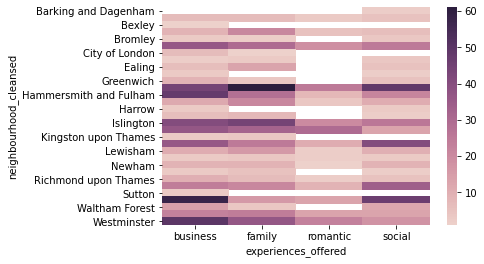

In [27]:
#визуализируем данные
sns.heatmap(forpivot,cmap=sns.cubehelix_palette(as_cmap=True))